In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pylab as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('fast')

from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

# RED NEURONAL FEEDFORWAD

In [211]:
# Loading the data
raw_data = pd.read_csv('delanteros.csv', sep=';',encoding='latin-1')

# print the shape
print(raw_data.shape)

#runs the first 5 rows
raw_data.head()

(1962, 17)


,Nombre,Fecha,Competicion,Jornadas,Titular,Minutos,Goles,Asistencias,Tiros,Tiros a puerta,Amarila,Roja,Toques,Presion,Entradas,Intercepciones,Bloqueos
0,Joselu,20/08/2017,Premier League,1,N,39,0,0,4.0,4.0,1,0,20.0,6.0,0.0,0.0,0.0
1,Joselu,26/08/2017,Premier League,2,Y,71,1,0,2.0,1.0,0,0,33.0,22.0,1.0,0.0,3.0
2,Joselu,10/09/2017,Premier League,3,Y,77,0,0,6.0,4.0,0,0,45.0,17.0,0.0,0.0,1.0
3,Joselu,16/09/2017,Premier League,4,Y,77,0,0,5.0,1.0,0,0,28.0,13.0,0.0,1.0,0.0
4,Joselu,24/09/2017,Premier League,5,Y,70,0,0,2.0,0.0,0,0,17.0,9.0,1.0,0.0,1.0


In [212]:
# Deleting the NULL values
raw_data = raw_data.dropna(subset = ['Tiros'])
raw_data = raw_data.dropna(subset = ['Tiros a puerta'])

# filtering out the last 2 columns
raw_data = raw_data[['Nombre','Fecha','Jornadas','Titular','Minutos','Goles','Asistencias','Tiros','Tiros a puerta']]

In [213]:
# Filtering out the data we need - GDP per Capita
forecast_data = raw_data

forecast_data = forecast_data[~forecast_data['Nombre'].isin(['Lucas Boyé', 'Luis Javier Suárez', 'Alexander Isak', 'Rafa Mir'])]

# print the shape
print(forecast_data.shape)

forecast_data.head()

(1531, 9)


,Nombre,Fecha,Jornadas,Titular,Minutos,Goles,Asistencias,Tiros,Tiros a puerta
0,Joselu,20/08/2017,1,N,39,0,0,4.0,4.0
1,Joselu,26/08/2017,2,Y,71,1,0,2.0,1.0
2,Joselu,10/09/2017,3,Y,77,0,0,6.0,4.0
3,Joselu,16/09/2017,4,Y,77,0,0,5.0,1.0
4,Joselu,24/09/2017,5,Y,70,0,0,2.0,0.0


In [214]:
# Limiting the columns we need
forecast_data = forecast_data[['Nombre','Jornadas','Goles']]
forecast_data.head()

,Nombre,Jornadas,Goles
0,Joselu,1,0
1,Joselu,2,1
2,Joselu,3,0
3,Joselu,4,0
4,Joselu,5,0


In [215]:
#Original Data
original = forecast_data[forecast_data['Nombre'] == 'Karim Benzema']
original1 = original[['Jornadas', 'Goles']]

# set the Jornada into index
original1.set_index('Jornadas', inplace=True)
original1

,Goles
Jornadas,
1,0
2,2
3,2
4,0
5,0
...,...
114,0
115,1
116,0


In [216]:
print(original1.index.min())
print(original1.index.max())

1
118


In [217]:
original1.describe()

,Goles
count,118.000000
mean,0.635593
std,0.791680
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,3.000000


In [218]:
original1_df1 = original1.diff(periods=1)
original1_df1.dropna(inplace=True)

Son un total de 118 registros con una media de 0.635593 y desviación  de 0.791680. Por lo que estaremos entre 0 y 1.427 goles

In [219]:
PASOS=4
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# load dataset
values = original1_df1.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, PASOS, 1)
reframed.head()

,var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
4,0.666667,0.000000,-0.666667,0.0,0.0
5,0.000000,-0.666667,0.000000,0.0,0.0
6,-0.666667,0.000000,0.000000,0.0,0.0
7,0.000000,0.000000,0.000000,0.0,0.0
8,0.000000,0.000000,0.000000,0.0,0.0


In [220]:
# split into train and test sets
values = reframed.values
n_train_days = 118 - (22+PASOS) # 92 entreno y predigo 26
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
x_train, y_train = train[:, :-1], train[:, -1]
x_val, y_val = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(92, 1, 4) (92,) (21, 1, 4) (21,)


In [221]:
def crear_modeloFF():
    model = Sequential() 
    model.add(Dense(PASOS, input_shape=(1,PASOS),activation='tanh'))
    model.add(Flatten())
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_absolute_error',optimizer='Adam',metrics=["mse"])
    model.summary()
    return model

In [222]:
EPOCHS=70
 
model = crear_modeloFF()
 
history=model.fit(x_train,y_train,epochs=EPOCHS,validation_data=(x_val,y_val),batch_size=PASOS)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 1, 4)              20        
                                                                 
 flatten_11 (Flatten)        (None, 4)                 0         
                                                                 
 dense_23 (Dense)            (None, 1)                 5         
                                                                 
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
Epoch 1/70
23/23 [==============================] - 1s 14ms/step - loss: 0.4121 - mse: 0.2605 - val_loss: 0.5550 - val_mse: 0.4430
Epoch 2/70
23/23 [==============================] - 0s 7ms/step - loss: 0.3987 - mse: 0.2490 - val_loss: 0.5437 - val_mse: 0.4261
Epoch 3/70
23/23 [==============================] - 0s 9ms/s

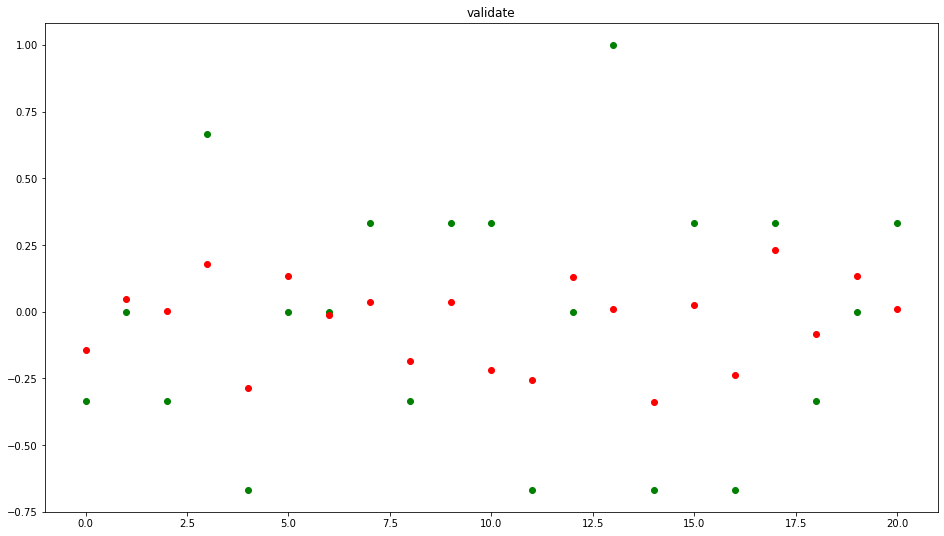

In [223]:
results=model.predict(x_val)
plt.scatter(range(len(y_val)),y_val,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.title('validate')
plt.show()

In [224]:
ultimosDias = original1[112:118]
ultimosDias

,Goles
Jornadas,
113,2
114,0
115,1
116,0
117,0
118,1


In [225]:
values = ultimosDias.values
values = values.astype('float32')
# normalize features
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, PASOS, 1)
reframed.drop(reframed.columns[[4]], axis=1, inplace=True)
reframed.head(6)

,var1(t-4),var1(t-3),var1(t-2),var1(t-1)
4,1.0,-1.0,0.0,-1.0
5,-1.0,0.0,-1.0,-1.0


In [226]:
values = reframed.values
x_test = values[-1:, :]
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
x_test

array([[[-1.,  0., -1., -1.]]], dtype=float32)

In [227]:
def agregarNuevoValor(x_test,nuevoValor):
    for i in range(x_test.shape[2]-1):
        x_test[0][0][i] = x_test[0][0][i+1]
    x_test[0][0][x_test.shape[2]-1]=nuevoValor
    return x_test
 
results=[]
for i in range(4):
    parcial=model.predict(x_test)
    results.append(parcial[0])
    print(x_test)
    x_test=agregarNuevoValor(x_test,parcial[0])

[[[-1.  0. -1. -1.]]]
[[[ 0.         -1.         -1.          0.31694505]]]
[[[-1.         -1.          0.31694505  0.24932565]]]
[[[-1.0000000e+00  3.1694505e-01  2.4932565e-01 -2.1226704e-05]]]


In [228]:
adimen = [x for x in results]    
inverted = scaler.inverse_transform(adimen)
inverted

array([[1.31694505],
       [1.24932565],
       [0.99997877],
       [0.89148224]])

<AxesSubplot:>

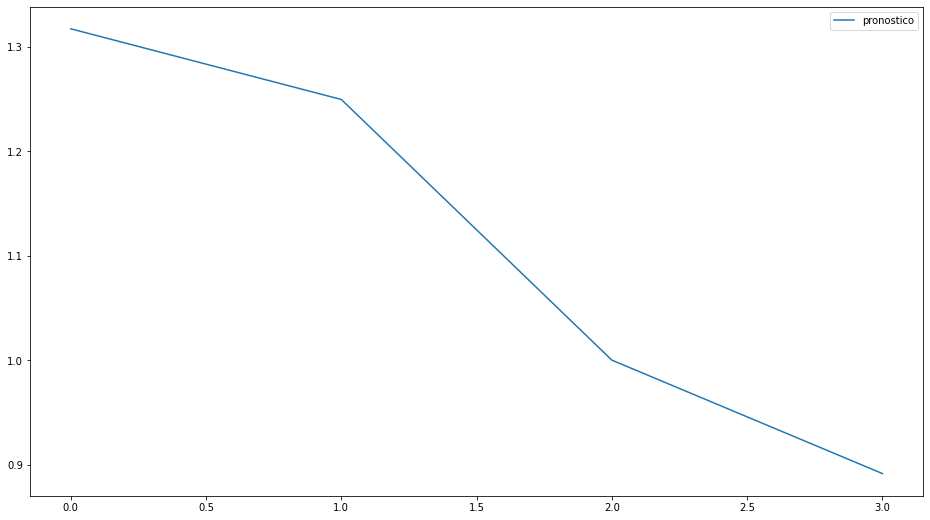

In [229]:
prediccion1Goles4JornadasSiguientes = pd.DataFrame(inverted)
prediccion1Goles4JornadasSiguientes.columns = ['pronostico']
prediccion1Goles4JornadasSiguientes.plot()